<a href="https://colab.research.google.com/github/4may/SuperResolutionSurvey/blob/master/FSRCNN_IMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  FSRCNNで超解像してみよう

FSRCNNで超解像するために、以下の手順を踏む。

1. データの前処理
2. モデリング
3. 学習
4. テスト

## 1.データの前処理

論文では91-imageとgeneral-100 imageを使っていたが、まずは91-imageだけを使ってみよう。

91-imageが正しく読み込めているか確認する。

In [1]:
!unzip "91-image.zip"

Archive:  91-image.zip
  inflating: T91/t1.png              
  inflating: T91/t10.png             
  inflating: T91/t11.png             
  inflating: T91/t12.png             
  inflating: T91/t13.png             
  inflating: T91/t14.png             
  inflating: T91/t15.png             
  inflating: T91/t16.png             
  inflating: T91/t17.png             
  inflating: T91/t18.png             
  inflating: T91/t19.png             
  inflating: T91/t2.png              
  inflating: T91/t20.png             
  inflating: T91/t21.png             
  inflating: T91/t22.png             
  inflating: T91/t23.png             
  inflating: T91/t24.png             
  inflating: T91/t25.png             
  inflating: T91/t26.png             
  inflating: T91/t27.png             
  inflating: T91/t28.png             
  inflating: T91/t29.png             
  inflating: T91/t3.png              
  inflating: T91/t30.png             
  inflating: T91/t31.png             
  inflating: T91/t32.png   

In [0]:
import cv2
import matplotlib.pyplot as plt

In [0]:
def show_image(filepath):
  plt.figure(figsize=(5, 5))
  img = cv2.imread(filepath)
  print("shape:", img.shape)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

shape: (176, 197, 3)


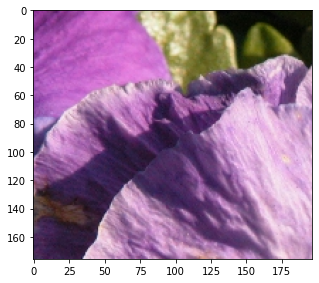

In [10]:
show_image("T91/t1.png")

shape: (334, 435, 3)


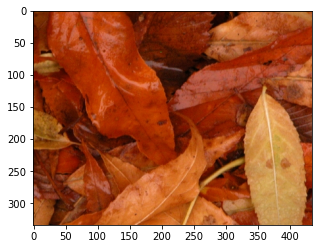

In [11]:
show_image("T91/tt9.png")

読み込めてるね！

それでは、画像を一覧として取得しよう。91-imageデータをtensorflowで扱えるようにするために、tensorflow.data.Dataset.from_tensor_slices関数を使ってtensorflow.data.Datasetオブジェクトを取得しよう。

大まかな流れは以下の通り。

1. pathlib.Path関数を使ってPosixPathオブジェクトを取得する
2. glob関数を使って、pngファイルの一覧を取得する。
3. from_tensor_slices関数を使って、pathのDatasetオブジェクトを取得する
4. map関数を使って、手順3のDatasetオブジェクトの各ファイルパスから画像ロード&前処理をする
5. 学習のための準備をする。
  * shuffle
  * repeat
  * batch

画像のロード方法は[ここ](https://www.tensorflow.org/tutorials/load_data/images?hl=ja#top_of_page)を参考にする。

**step1**

In [0]:
import re
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [0]:
#入力画像が格納されているフォルダのパス
INPUT_IMAGE_DIR_PATH = "./T91"

#入力画像のサイズ
IMG_SIZE = (32, 32, 3)

#入力画像のスケール
INPUT_SCALE = 4

#バッチサイズ
BATCH_SIZE = 16

#エポック数
EPOCHS = 500

In [0]:
import pathlib
data_root = pathlib.Path(INPUT_IMAGE_DIR_PATH)

In [95]:
data_root

PosixPath('T91')

**step2**

In [0]:
all_image_paths = list(data_root.glob('**/*.png'))
#Path関数の戻り値の型はPosixPathオブジェクトなので、str型に変えておく。
all_image_paths = [str(path) for path in all_image_paths]

In [94]:
all_image_paths[:5]

['T91/t38.png', 'T91/t8.png', 'T91/t24.png', 'T91/t11.png', 'T91/t55.png']

In [103]:
image_count = len(all_image_paths)
image_count

91

**step3**

In [0]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [97]:
path_ds

<TensorSliceDataset shapes: (), types: tf.string>

**step4**

In [0]:
def preprocess_image(image):
  image = tf.image.decode_png(image, channels=3)
  image = tf.image.resize(image, [IMG_SIZE[0], IMG_SIZE[1]])
  image /= 255
  return image

In [0]:
def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  image = preprocess_image(image)
  return image

In [0]:
image_ds = path_ds.map(load_and_preprocess_image)

In [168]:
image_ds

<MapDataset shapes: (32, 32, 3), types: tf.float32>

**step5**

In [0]:
#buffer_sizeを画像の枚数と同じにすると、完全にシャッフルされる
tf.random.set_seed(1)
ds = image_ds.shuffle(buffer_size=image_count)
ds_valid = ds.take(10).batch(BATCH_SIZE)
ds_train = ds.skip(10).batch(BATCH_SIZE)

In [170]:
ds_valid

<BatchDataset shapes: (None, 32, 32, 3), types: tf.float32>

In [171]:
ds_train

<BatchDataset shapes: (None, 32, 32, 3), types: tf.float32>

## 2.モデリング

ここでは、d=32, s=5, m=1としてFSRCNN(32, 5, 1)を実装する。

FSRCNNのアーキテクチャ

※Conv2D(フィルタサイズ、フィルタの枚数、チャンネル数)

* Input layer : 
* Feature Extraction layer : Conv2D(5, d, 1)
* Shrinking layer : Conv2D(1, s, d)
* Mapping layer : Conv2D(3, s, s) ※m=4なので、4枚
* Expanding layer : Conv2D(1, d, s)
* Deconvolution layer : Conv2DTranspose(9, 1, s)

その他情報

* 活性化関数：PReLU関数 ※Conv2D layerの後に配置
* 損失関数：MSE
* metrics:PSNR

モデリングや！

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import PReLU
from tensorflow.keras.backend import mean, square

In [0]:
#入力層
#input = Input(shape=(IMG_SIZE[0]/INPUT_SCALE, IMG_SIZE[1]/INPUT_SCALE, 1))
input_layer = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

#畳み込み層
#特長量抽出layer
feature_layer = Conv2D(filters=32, 
                       kernel_size=(5, 5), 
                       padding='same', 
                       kernel_initializer='he_normal',
                       name='feature_layer')

#縮小layer
shrinking_layer = Conv2D(filters=5, 
                       kernel_size=(1, 1), 
                       padding='same', 
                       kernel_initializer='he_normal',
                       name='shrinking_layer')

#非線形変換layer
mapping_layer1 = Conv2D(filters=5, 
                        kernel_size=(3, 3), 
                        padding='same', 
                        kernel_initializer='he_normal',
                        name='mapping_layer1')

#拡張layer(計算効率化)
expanding_layer = Conv2D(filters=32, 
                       kernel_size=(1, 1), 
                       padding='same', 
                       kernel_initializer='he_normal',
                       name='expanding_layer')

#HR画像生成
deconvolution_layer = Conv2DTranspose(filters=1,
                                      kernel_size=(9, 9), 
                                      padding='same',
                                      name='deconvolution_layer')

#モデル構築
model = Sequential()
model.add(input_layer)
model.add(feature_layer)
model.add(PReLU())
model.add(shrinking_layer)
model.add(PReLU())
model.add(mapping_layer1)
model.add(PReLU())
model.add(expanding_layer)
model.add(PReLU())
model.add(deconvolution_layer)

In [0]:
#入力層
#input = Input(shape=(IMG_SIZE[0]/INPUT_SCALE, IMG_SIZE[1]/INPUT_SCALE, 1))
input_layer = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

#畳み込み層
#特長量抽出layer
feature_layer = Conv2D(filters=32, 
                       kernel_size=(5, 5), 
                       padding='same', 
                       kernel_initializer='he_normal',
                       name='feature_layer',
                       activation='relu')

#縮小layer
shrinking_layer = Conv2D(filters=5, 
                       kernel_size=(1, 1), 
                       padding='same', 
                       kernel_initializer='he_normal',
                       name='shrinking_layer',
                       activation='relu')

#非線形変換layer
mapping_layer1 = Conv2D(filters=5, 
                        kernel_size=(3, 3), 
                        padding='same', 
                        kernel_initializer='he_normal',
                        name='mapping_layer1',
                        activation='relu')

#拡張layer(計算効率化)
expanding_layer = Conv2D(filters=32, 
                       kernel_size=(1, 1), 
                       padding='same', 
                       kernel_initializer='he_normal',
                       name='expanding_layer',
                       activation='relu')

#HR画像生成
deconvolution_layer = Conv2DTranspose(filters=1,
                                      kernel_size=(9, 9), 
                                      padding='same',
                                      name='deconvolution_layer')

#モデル構築
model = Sequential()
model.add(input_layer)
model.add(feature_layer)
model.add(shrinking_layer)
model.add(mapping_layer1)
model.add(expanding_layer)
model.add(deconvolution_layer)

In [0]:
def tf_log10(x):
  numerator = tf.log(x)
  denominator = tf.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator

def PSNR(y_true, y_pred):
  max_pixel = 1.0
  return 10.0 * tf_log10((max_pixel ** 2) / (mean(square(y_pred - y_true))))

In [0]:
model.build(input_shape=(None, 32, 32, 3))
model.compile(optimizer='adam', loss='mse', metrics=[PSNR, 'accuracy'])

In [163]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_layer (Conv2D)       (None, 32, 32, 32)        2432      
_________________________________________________________________
p_re_lu_35 (PReLU)           (None, 32, 32, 32)        32768     
_________________________________________________________________
shrinking_layer (Conv2D)     (None, 32, 32, 5)         165       
_________________________________________________________________
p_re_lu_36 (PReLU)           (None, 32, 32, 5)         5120      
_________________________________________________________________
mapping_layer1 (Conv2D)      (None, 32, 32, 5)         230       
_________________________________________________________________
p_re_lu_37 (PReLU)           (None, 32, 32, 5)         5120      
_________________________________________________________________
expanding_layer (Conv2D)     (None, 32, 32, 32)      

## 3.学習

作成したSRモデルを使って、学習してみよう。

In [164]:
history = model.fit(ds_train, epochs=EPOCHS, validation_data=ds_valid)

Epoch 1/500


ValueError: ignored